In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from astropy.cosmology import Planck18 as cosmo
from scipy.interpolate import interp1d

import utils as ut
import props as p
import E_lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

<module 'E_lines' from 'c:\\Users\\juzz\\Desktop\\TIM\\LIMxJuzz\\LIM\\TIMxGal\\E_lines.py'>

In [2]:

#TIM = p.SpaceTIM
TIM = p.TIM
#TIM = p.TIM2

saveSig = False #If True will save over values for whichever version of TIM is indicated by saveWhich
saveWhich = 'TIM2' # Choices are 'TIM2' or 'TIMS'

#GAL = p.AstroDeep
GAL = p.Euclid
CII = l.CII

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 1

colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

In [3]:
# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bin_zs = [b.center.value for b in bins]

bands = ['SW', 'SW', 'LW', 'LW'] 

print("TIM bins:")
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

TIM bins:
z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


In [4]:
LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

for lsb in LSbins:
    print(lsb.cell_noise(TIM.time))

220898022790.44324 Mpc3 Jy2 / s2
418341284343.32904 Mpc3 Jy2 / s2
248498105175.97574 Mpc3 Jy2 / s2
380653079150.8324 Mpc3 Jy2 / s2


In [5]:
LSbins[1].ins

In [6]:
#Sanity check on the kscale of the bin LoS
for lsb in LSbins:
    print(np.around(lsb.LoS, 2), 'or k = ', np.around(2*np.pi / lsb.LoS, 4))

508.99 Mpc or k =  0.0123 1 / Mpc
439.17 Mpc or k =  0.0143 1 / Mpc
497.76 Mpc or k =  0.0126 1 / Mpc
416.27 Mpc or k =  0.0151 1 / Mpc


In [7]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

In [8]:
# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]

num_kbins

C:\Users\juzz\AppData\Local\Temp\ipykernel_11828\2981313433.py:9: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


[11, 11, 10, 10]

In [9]:
print(k_mags[3])

[[[0.         0.01519455 0.03038911 ... 0.04558366 0.03038911 0.01519455]
  [0.11986688 0.12082609 0.12365907 ... 0.12824172 0.12365907 0.12082609]
  [0.23973376 0.2402148  0.24165217 ... 0.24402898 0.24165217 0.2402148 ]
  ...
  [0.35960064 0.35992151 0.36088241 ... 0.36247826 0.36088241 0.35992151]
  [0.23973376 0.2402148  0.24165217 ... 0.24402898 0.24165217 0.2402148 ]
  [0.11986688 0.12082609 0.12365907 ... 0.12824172 0.12365907 0.12082609]]

 [[0.61531665 0.61550422 0.61606661 ... 0.61700279 0.61606661 0.61550422]
  [0.62688328 0.6270674  0.62761942 ... 0.62853839 0.62761942 0.6270674 ]
  [0.66036872 0.66054351 0.66106758 ... 0.66194012 0.66106758 0.66054351]
  ...
  [0.71269011 0.71285207 0.71333771 ... 0.71414639 0.71333771 0.71285207]
  [0.66036872 0.66054351 0.66106758 ... 0.66194012 0.66106758 0.66054351]
  [0.62688328 0.6270674  0.62761942 ... 0.62853839 0.62761942 0.6270674 ]]

 [[1.23063329 1.23072709 1.23100845 ... 1.23147723 1.23100845 1.23072709]
  [1.23645718 1.236550

In [10]:
from E_lines import CII
CII.nu.to(u.THz)

<Quantity 1.9005481 THz>

In [11]:
#Euclid gives their spectral resolution in nm/pixel https://arxiv.org/pdf/2405.13493 table 2
#EUnumPix = 2040*2040
#EURes = (c.c/(1.3 * EUnumPix* u.nm)).to(u.GHz)


In [12]:
# resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

EU_s_pars  = [250./400. *  s_par for s_par in s_pars] #Euclid's blue grism resolving power in ratio to TIM's.
#EU_s_pars = [0,0,0,0]
#this is the most conservative (and lazy) approach.

In [13]:
[print(f"sPar: {sPar}, sPerp: {sPerp}, galPar: {galPar}") for sPar, sPerp, galPar in zip(s_pars, s_perps, EU_s_pars)]

sPar: 5.522495604826229, sPerp: 0.11755244692217426, galPar: 3.4515597530163933
sPar: 6.2842140098992685, sPerp: 0.1516503189988713, galPar: 3.927633756187043
sPar: 5.289537008577563, sPerp: 0.24571221408768276, galPar: 3.3059606303609765
sPar: 5.8534643024337445, sPerp: 0.28908943552124405, galPar: 3.65841518902109


[None, None, None, None]

In [14]:
# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * (s_par**2 + EU_s_par**2) / 2))
                #np.sqrt(np.exp(-kxyzs[2][0, 0, :]**2 * (s_par**2 + EU_s_par**2) / 2)))
            
                for kxyzs, s_perp, s_par, EU_s_par in zip(k_xyz_modes, s_perps, s_pars, EU_s_pars)]

autoWindows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2))
                #np.sqrt(np.exp(-kxyzs[2][0, 0, :]**2 * (s_par**2 + EU_s_par**2) / 2)))

                for kxyzs, s_perp, s_par, EU_s_par in zip(k_xyz_modes, s_perps, s_pars, EU_s_pars)]

[[<matplotlib.lines.Line2D at 0x21d664140d0>],

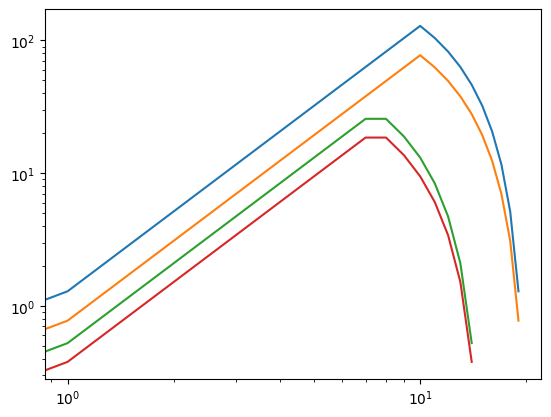

In [15]:
[plt.loglog(kxyzs[0][:, 0, 0]**2) for kxyzs in k_xyz_modes]



In [16]:
print(TIM['SW'].FWHM, TIM['LW'].FWHM)

0.000169885 rad 0.000224785 rad


In [17]:
[print(lsb.z.transScale(lsb.az),
        lsb.z.transScale(lsb.el),
        lsb.z.LoSmax()) for lsb in LSbins]

5.687766073205424 Mpc 28.43883036602712 Mpc 508.98871808178956 Mpc
7.33758898241917 Mpc 36.68794491209585 Mpc 439.16986983488067 Mpc
8.985132904266571 Mpc 44.92566452133286 Mpc 497.75798336030624 Mpc
10.57133854343462 Mpc 52.8566927171731 Mpc 416.26968590569487 Mpc


[None, None, None, None]

In [18]:
[print(ut.transverse_scale(bin.ins.FWHM, bin.z.center),
       bin.dLoS)
         for bin in LSbins]

0.27681485835477265 Mpc 13.004483348840122 Mpc
0.35710921101387993 Mpc 14.798193117775119 Mpc
0.5786080470426114 Mpc 12.45590777673149 Mpc
0.6807535975721076 Mpc 13.783855072244084 Mpc


[None, None, None, None]

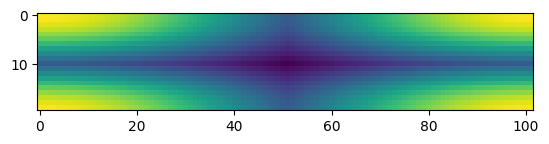

In [19]:
plt.figure()
plt.imshow(windows[0][:, :, 0])
plt.show()
plt.close()

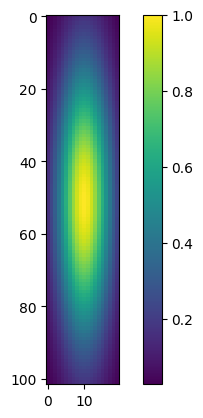

In [20]:
plt.figure()
plt.imshow(np.fft.fftshift(windows[0][:, :, 0]).T ** 2)
plt.colorbar()
plt.show()
plt.close()

In [21]:
# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=False) 


results = camb.get_results(pars)

Note: redshifts have been re-sorted (earliest first)


In [31]:
k_mags[0].shape

(20, 102, 39)

In [23]:
binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]
print(z_idxs)

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

[0, 1, 2, 2]


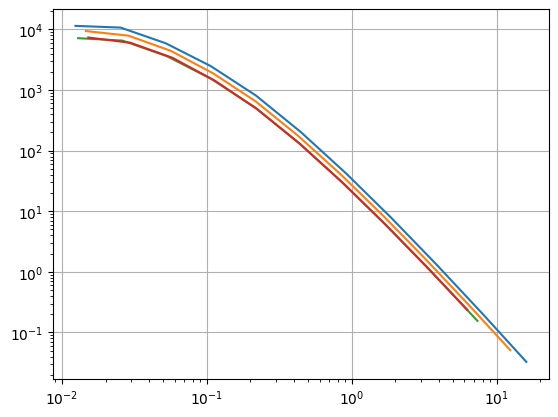

In [24]:
[plt.loglog(ks,Pm) for (ks, Pm) in Pms]
plt.grid()

In [25]:
kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

nModes = []
for j, (ks,ws) in enumerate(zip(k_mags, windows)):
    kflat = ks.flatten()
    wflat = ws.flatten()
    kNonZero = kflat[np.nonzero(kflat)[0]]
    edges = kbin_edges[j]
    
    nModeList = []
    for i in np.arange(len(edges)-1):
        #print(i, len(edges))
        if i+1 == len(edges):
            wSum = (np.sum(wflat[kflat>edges[i]]))
        else:
            wSum = (np.sum(wflat[(kflat>edges[i]) & (kflat<=edges[i+1])]))
        nModeList.append(wSum/2.) # accounting for double counting.
    nModeList = np.asarray(nModeList)
    nModes.append(np.asarray(nModeList))

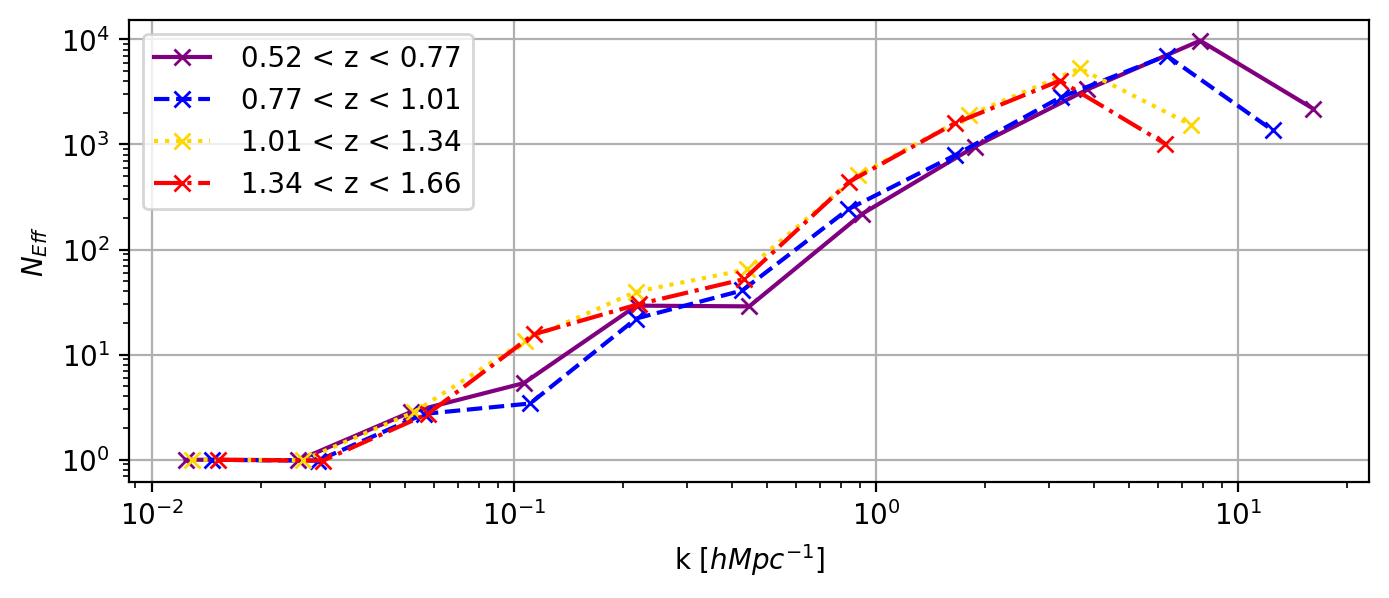

In [26]:
plt.figure(dpi = 200, figsize = (8,3))
for i,((ks,_), nums, col) in enumerate(zip(Pms,nModes, colors)):
    plt.loglog(ks,nums, color = col, linestyle = linestyles[i], marker = 'x',
               label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel(r'$N_{Eff}$')

plt.grid()
plt.legend()

In [27]:
window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

autoWindows

auto_window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(autoWindows, k_mags, kbin_edges)]

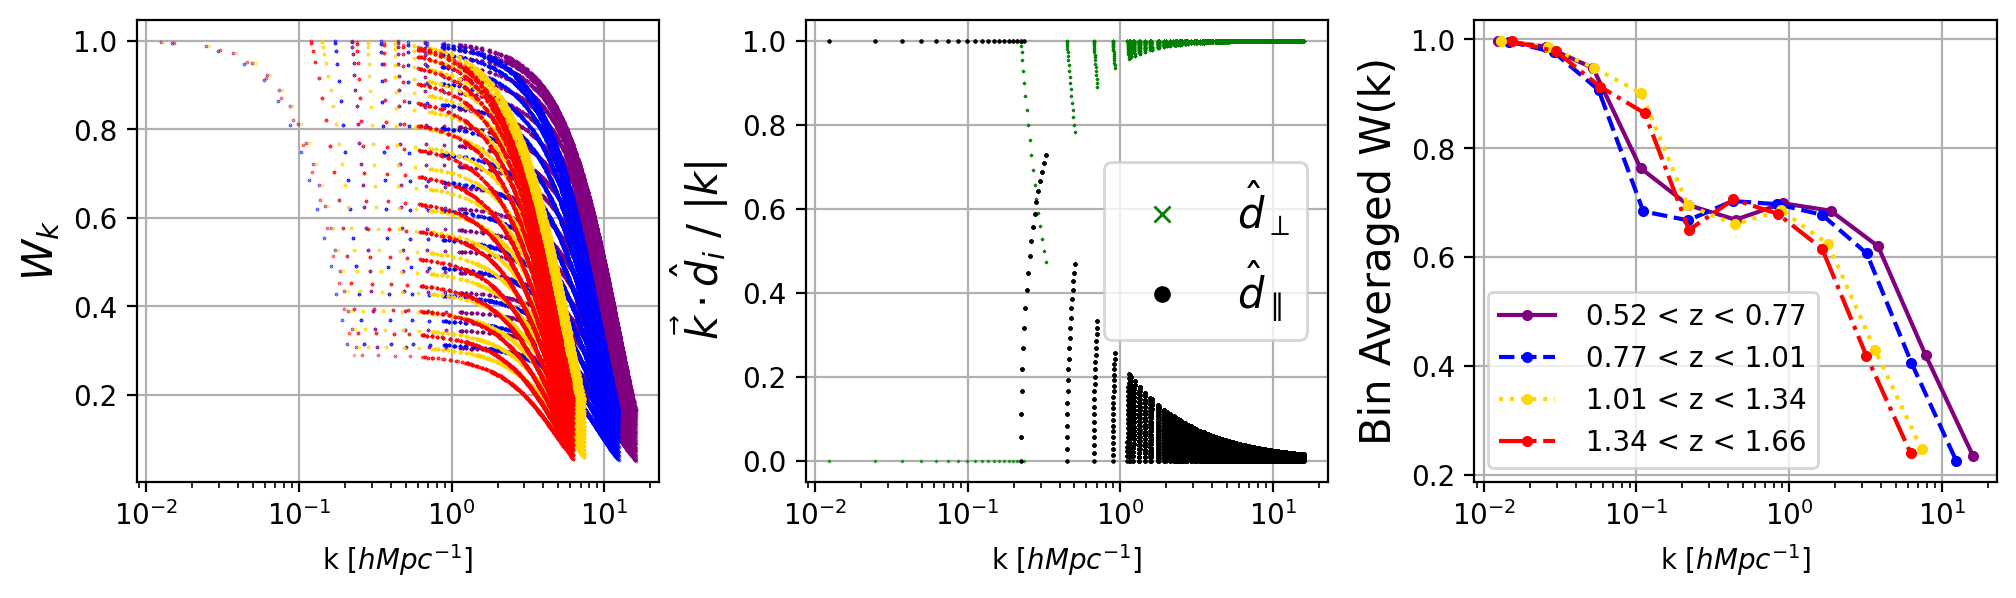

In [28]:
fig, (scatter, component, ave) = plt.subplots(1,3, figsize = (12,3), dpi = 200)#, sharex = True)

for i in range(len(k_mags)):
    scatter.semilogx(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
    linestyle='None', label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}", markersize=.6, color = colors[i], alpha = .5)
scatter.grid()

for i in range(len(Pms)):
    ave.semilogx(Pms[i][0], window_avgs[i], label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}", marker='.', 
             color = colors[i], linestyle = linestyles[i] )
    
    
ave.grid()
ave.legend()
    

# making a plot for bin1
component.semilogx(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='x',
               linestyle='None', markersize=.6, alpha = 0.5, label = r'$\hat{d}_\perp$', color = 'green')
component.semilogx(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', 
               markersize=1, label = r'$\hat{d}_{\parallel} $', color = 'black')
component.grid()
compLeg = component.legend(fontsize = 15, markerscale = 10)
for lh in compLeg.legend_handles:
    lh.set_alpha(1)

scatter.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
component.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
ave.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)

component.set_ylabel(r'$ \vec{k} \cdot \hat{d}_{i}$ / $|k|$', fontsize = 15)
scatter.set_ylabel(r'$W_k$', fontsize = 15)
ave.set_ylabel('Bin Averaged W(k)', fontsize = 15)
fig.subplots_adjust(hspace=0, wspace=0.28)

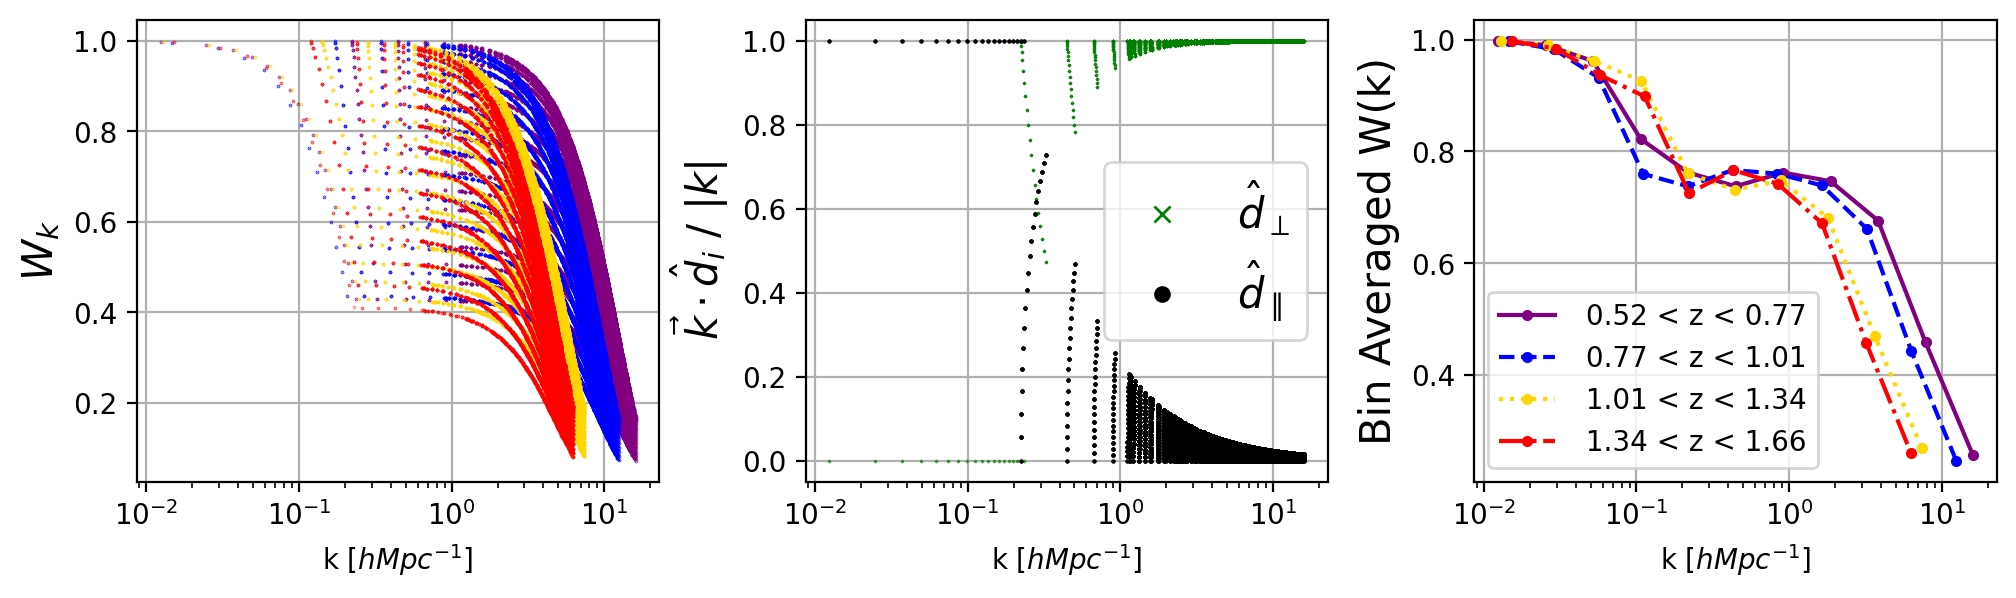

In [29]:
fig, (scatter, component, ave) = plt.subplots(1,3, figsize = (12,3), dpi = 200)#, sharex = True)

for i in range(len(k_mags)):
    scatter.semilogx(k_mags[i].flatten(), autoWindows[i].flatten(), marker='.', \
    linestyle='None', label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}", markersize=.6, color = colors[i], alpha = .5)
scatter.grid()

for i in range(len(Pms)):
    ave.semilogx(Pms[i][0], auto_window_avgs[i], label = f" {bins[i].front:.2f} < z < {bins[i].back:.2f}", marker='.', 
             color = colors[i], linestyle = linestyles[i] )
    
    
ave.grid()
ave.legend()
    

# making a plot for bin1
component.semilogx(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='x',
               linestyle='None', markersize=.6, alpha = 0.5, label = r'$\hat{d}_\perp$', color = 'green')
component.semilogx(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', 
               markersize=1, label = r'$\hat{d}_{\parallel} $', color = 'black')
component.grid()
compLeg = component.legend(fontsize = 15, markerscale = 10)
for lh in compLeg.legend_handles:
    lh.set_alpha(1)

scatter.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
component.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
ave.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)

component.set_ylabel(r'$ \vec{k} \cdot \hat{d}_{i}$ / $|k|$', fontsize = 15)
scatter.set_ylabel(r'$W_k$', fontsize = 15)
ave.set_ylabel('Bin Averaged W(k)', fontsize = 15)
fig.subplots_adjust(hspace=0, wspace=0.28)

In [30]:
sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([CII.Inu(sfrd, z).value for sfrd, z in zip(sfrds, bin_zs)])

salpeterConversion = True
if salpeterConversion: Iciis = Iciis * .86 #Converting from salpeter IMF (used in MD14) to Modern IMF.

NameError: name 'cosmo' is not defined

In [ ]:
fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
b_CII = 1.7 
b_gal = 1.7 
Igal = 1
bstar = b_CII*b_gal

x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
#where fs is SFRD from the catalogue divided by the corresponding madau dickinson curve point.
PxGs = [(bstar * Icii * Igal * Pm) + x_shot 
            for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]


In [ ]:
x_shots

array([154580.00828759, 245161.01457392, 383265.22223843, 506421.00655609])

The following cell will calculate CII auto power spectra and galaxy survey auto power to use in the $\sigma_P$ calculation.
Here $\sigma_P \equiv \sqrt{VAR[P_x]}$:

$$VAR[P_x] = \frac{1}{2N_{mode}} [P^2_x + (P_{[CII]} + \frac{P_N}{W}) \cdot (P_{Gal} + \frac{1}{n_{gal}})]$$

OR

$$VAR[P_x] = \frac{1}{2N_{mode}} [P^2_x + (P_N + P_{[CII]}) \cdot (P_{Gal} + \frac{1}{n_{gal}})]$$
but where $$N_{mode} = \int dk^3 W_{TIM}(k_x, k_y, k_z) \cdot W_{GAL}(k_x, k_y, k_z) $$

So, an issue: here the dk cubed gives units of inverse volume where Nmodes should be unitless. Should there be some normalization here that cancels the volume units?

~*Breysse and Alexandroff 2019*

In [ ]:
#### Trying to add in variance terms


TIM_shot = [1.2e9,2.2e9,3e9,3e9] # TODO: Discuss a self consistent way of calculating these values.

P_TIM = [(b_CII**2 * ICII**2 * Pm + shot) for ICII, (_,Pm), shot in zip(Iciis, Pms, TIM_shot)]
N_TIM = [lsb.cell_noise(TIM.time).value for lsb, nm in zip(LSbins, nModes)]

var_TIM = [(PT + NT)**2/n for PT, NT,n in zip(P_TIM, N_TIM, nModes)]


P_gal = [b_gal**2*Pm for (_,Pm), ngal in zip(Pms, GAL.n_gals)]
SNR_TIM = [PT/np.sqrt(var) for PT, var in zip(P_TIM, var_TIM)] #This needs some nm and w factors added.

In [ ]:
N_TIM

[220898022790.44324, 418341284343.32904, 248498105175.97574, 380653079150.8324]

In [ ]:
clusterVar = [PT*PG/n
            for PT, n, PG in zip(P_TIM, nModes, P_gal)]

In [ ]:
[print(PT/NT) for PT, NT in zip(P_TIM, N_TIM)]

[0.92654076 0.86919738 0.48182766 0.20540184 0.0709635  0.02168292
 0.00882994 0.00606317 0.00553993 0.0054496  0.005435  ]
[0.57766497 0.48672051 0.27562818 0.11984957 0.04485546 0.01594992
 0.00774401 0.00577561 0.00535808 0.00527681 0.00526197]
[0.94540464 0.86357301 0.48305299 0.21049506 0.07828685 0.02886054
 0.01568937 0.01276541 0.0121946  0.01209274]
[0.65781791 0.54012772 0.30827748 0.13468869 0.05106093 0.01971245
 0.01065866 0.00846562 0.00799489 0.00790205]


[None, None, None, None]

In [ ]:
def galCross_Variance(ngal, numModes, Px, Pg, Pl, Nl, autoWindows):
    crossVar = [(PxG**2 + (NT/AW**2 + PT) * (1/n_gal +Pg)) / (2*nm)
        for n_gal, nm, PxG, Pg, PT, NT, AW in zip(ngal, numModes, Px, Pg, Pl, Nl, autoWindows)]
    return crossVar

In [ ]:
auto_window_avgs

[array([0.99844158, 0.99068219, 0.96185761, 0.8225245 , 0.76221414,
        0.73770904, 0.76216456, 0.74673831, 0.67623106, 0.45803871,
        0.25584999]),
 array([0.99718416, 0.98321169, 0.93224324, 0.75974014, 0.73774005,
        0.76674061, 0.76036193, 0.73909948, 0.66167439, 0.44219208,
        0.24645605]),
 array([0.99844158, 0.99068219, 0.96185761, 0.92666331, 0.76073542,
        0.73140326, 0.74807158, 0.68057259, 0.46901376, 0.26985519]),
 array([0.99736839, 0.98430357, 0.93651897, 0.89853747, 0.72512782,
        0.76657049, 0.74218829, 0.67123817, 0.45624219, 0.26093605])]

In [ ]:
VARx = galCross_Variance(GAL.n_gals, nModes, PxGs, P_gal, P_TIM, N_TIM, auto_window_avgs)
SNR_PxG = [PxG / np.sqrt(VARs)  for PxG, VARs in zip(PxGs, VARx)]

(100000000.0, 2e+16)

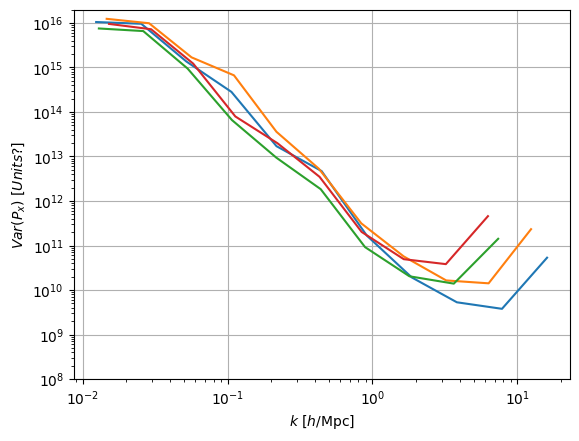

In [ ]:
[plt.loglog(ks, Var) for (ks,_), Var in zip(Pms, VARx)]
plt.grid()
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$Var(P_{x}) \ [Units?]$')

plt.ylim(1e8, 2e16)

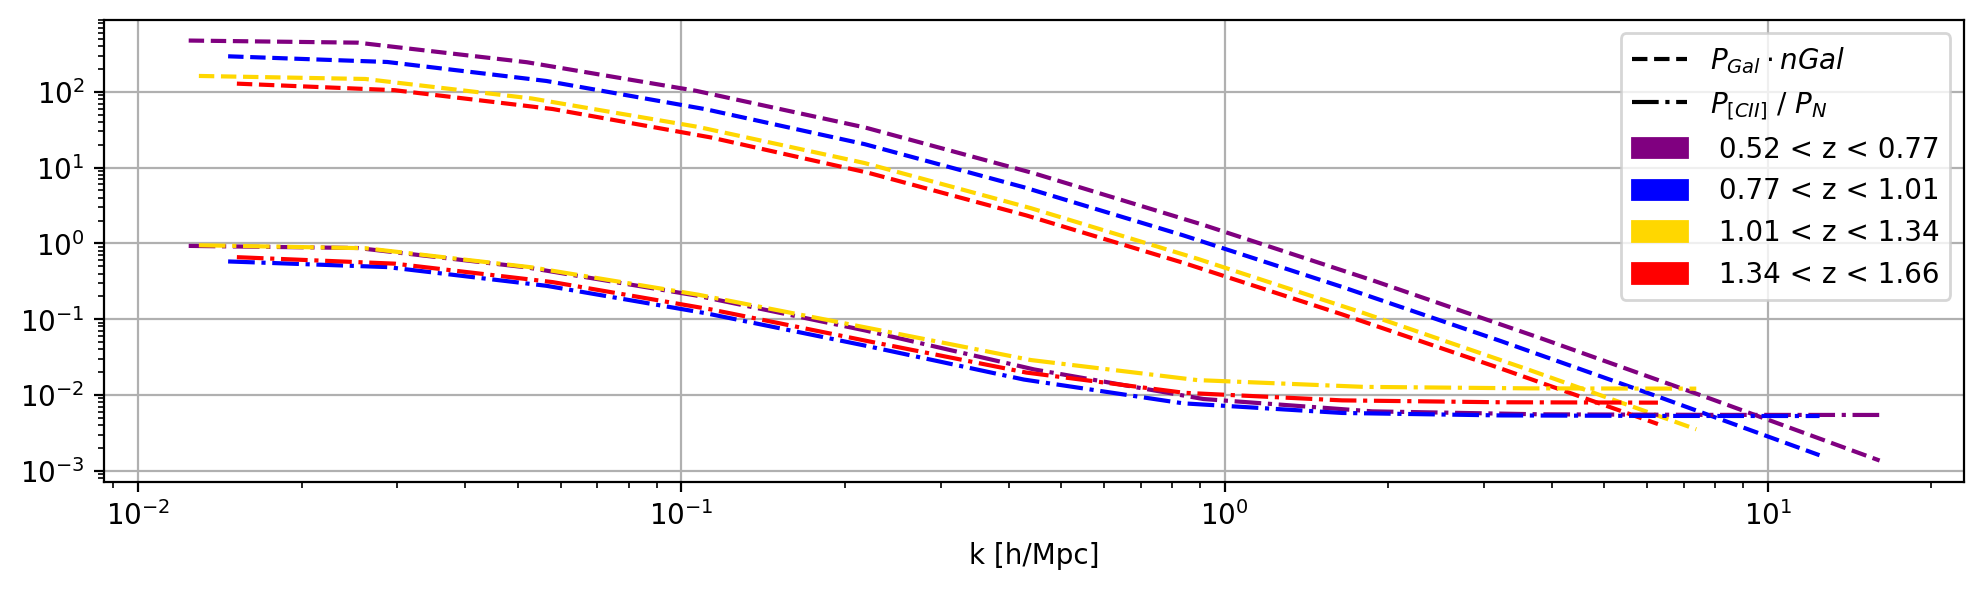

In [ ]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.figure(dpi = 200, figsize = (12,3))
[plt.loglog(ks, Pg/(1/ng), color = colors[i], ls = '--', label = r'P_{Gal} nGal') for i,((ks,_), Pg, ng) in enumerate(zip(Pms, P_gal, GAL.n_gals))]
#[plt.loglog(ks, SNRPxG, color = colors[i]) for i,((ks,_), SNRPxG) in enumerate(zip(Pms, SNR_PxG))]
[plt.loglog(ks, PT/NT, color = colors[i], ls = '-.', label = r'$P_{[CII]} / P_N$') 
     for i,((ks,_), PT, NT) in enumerate(zip(Pms, P_TIM, N_TIM))]
#[plt.axhline(1/ng, color = colors[i], ls = ':') for i,ng in enumerate(GAL.n_gals)]
#[plt.axhline(NT, color = colors[i], ls = '-.') for i,NT in enumerate(N_TIM)]

#dash = mpatches.Patch(color='black', ls = '--', label=r'$P_{Gal} nGal$')

plt.xlabel('k [h/Mpc]')
dash = mlines.Line2D([], [], color='black', marker='', ls = '--', label=r'$P_{Gal} \cdot nGal$')
dashDot = mlines.Line2D([], [], color='black', marker='', ls = '-.', label= r'$P_{[CII]}$ / $P_N$')
purple = mpatches.Patch(color='purple', label=f" {bins[0].front:.2f} < z < {bins[0].back:.2f}")
blue = mpatches.Patch(color='blue', label=f" {bins[1].front:.2f} < z < {bins[1].back:.2f}")
gold = mpatches.Patch(color='gold', label=f" {bins[2].front:.2f} < z < {bins[2].back:.2f}")
red = mpatches.Patch(color='red', label=f" {bins[3].front:.2f} < z < {bins[3].back:.2f}")

plt.legend(handles=[dash, dashDot, purple, blue, gold, red])
#plt.legend(handles=[dashDot])
plt.grid()

In [ ]:


# THIS IS USING THE WINDOWING THAT INCLUDES EUCLID - DON'T TRUST THIS
'''fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)
quad_SNR_TIM = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_TIM]

for i, PT in enumerate(P_TIM):
    power[i].loglog(Pms[i][0], PT, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(TIM_shot[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PT + var_TIM[i],
                   PT - var_TIM[i], color = colors[i], alpha = .4)
    power[i].set_title('Bin'+str(i+1))

    SNR[i].loglog(Pms[i][0], SNR_TIM[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNR_TIM[i],2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    #SNR[i].set_yticks(np.arange(0, 26, 4.0))

fig.subplots_adjust(hspace=0, wspace=0)

fig.suptitle('TIM Auto Power')
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()'''

"fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, \n                                 figsize=(8, 3.3), dpi = 200)\nquad_SNR_TIM = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_TIM]\n\nfor i, PT in enumerate(P_TIM):\n    power[i].loglog(Pms[i][0], PT, color = colors[i], linestyle = '--', alpha = .7)\n    power[i].axhline(TIM_shot[i], color = colors[i], linestyle = ':', alpha = .5)\n    power[i].fill_between(Pms[i][0], PT + var_TIM[i],\n                   PT - var_TIM[i], color = colors[i], alpha = .4)\n    power[i].set_title('Bin'+str(i+1))\n\n    SNR[i].loglog(Pms[i][0], SNR_TIM[i], color = colors[i], marker = 'x', \n                label = r'$\\sqrt{\\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNR_TIM[i],2)))\n    power[i].grid()\n    SNR[i].grid()\n    SNR[i].legend(fontsize = 7)\n    #SNR[i].set_yticks(np.arange(0, 26, 4.0))\n\nfig.subplots_adjust(hspace=0, wspace=0)\n\nfig.suptitle('TIM Auto Power')\nplt.rcParams.up

In [ ]:
#CAMB outputs lists of different ks for each bin so we can't sum them 'apples to apples.'
#So, we'll interpolate Cross powers, SNRs and noise values at matching ks across all bins.

PxG_Interp = [interp1d(ks, PxG) for (ks, _), PxG in zip(Pms, PxGs)]
SNR_PxG_Interp = [interp1d(ks, SNR) for (ks, _), SNR in zip(Pms, SNR_PxG)]
x_noise_Interp = [interp1d(ks, np.sqrt(VARs)) for (ks, _), VARs in zip(Pms, VARx)]

k4 = Pms[3][0] #isolate the list of k modes in bin 4. We'll use that as our default k list. 
aligned_PxGs = [interp(k4) for interp in PxG_Interp] #Interpolate the forecast signals in all bins at the modes in k4.
aligned_SNRs = np.nan_to_num([interp(k4) for interp in SNR_PxG_Interp]) #same for SNRs - nanToNum sets NaNs = 0.
aligned_x_noises = [interp(k4) for interp in x_noise_Interp]#and x_noises.

In [ ]:
#sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
quad_SNRs = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_PxG]

clustSNRs = [SNR[ks <= 1] for (ks,_), SNR in zip(Pms, SNR_PxG)]
quad_SNRs_Clust = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in clustSNRs]

#now sum each k as it is measured in each bin so we can report the total SNR per k bin.
SNR_by_k = np.zeros(len(aligned_SNRs[0]))
for SNRks in aligned_SNRs: SNR_by_k += SNRks**2
totQuadSNR = np.sqrt(np.sum(SNR_by_k))

In [ ]:
VARx

[array([1.04779222e+16, 9.57928598e+15, 1.36230735e+15, 2.82468497e+14,
        1.70270704e+13, 4.70880004e+12, 1.68331975e+11, 1.92199361e+10,
        5.31556104e+09, 3.79241688e+09, 5.33840539e+10]),
 array([1.23604862e+16, 9.83712914e+15, 1.68504369e+15, 6.65095769e+14,
        3.59620257e+13, 5.31216281e+12, 3.15023629e+11, 5.69913945e+10,
        1.64636171e+10, 1.41774572e+10, 2.33155212e+11]),
 array([7.50469074e+15, 6.56350344e+15, 9.44031151e+14, 6.57546428e+13,
        9.41158716e+12, 1.84529732e+12, 9.21042265e+10, 2.03942541e+10,
        1.39539068e+10, 1.41821786e+11]),
 array([9.50615967e+15, 7.21438253e+15, 1.21770956e+15, 7.93948221e+13,
        1.98844985e+13, 3.49855721e+12, 2.02223185e+11, 4.94177441e+10,
        3.82542710e+10, 4.56992341e+11])]

In [ ]:
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


C:\Users\juzz\AppData\Local\Temp\ipykernel_30148\1596046007.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


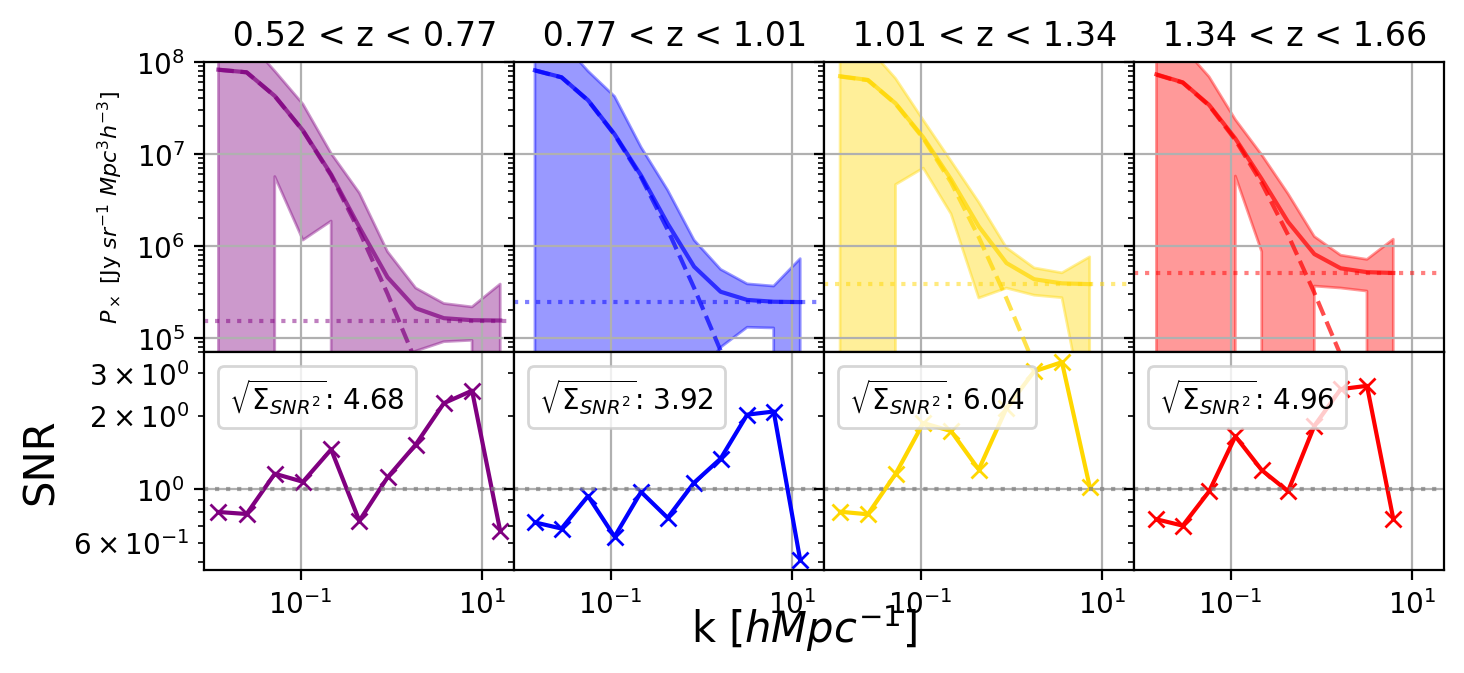

In [ ]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(PxGs):
    power[i].loglog(Pms[i][0], PxG - x_shots[i], color = colors[i], linestyle = '--', alpha = .7)
    power[i].loglog(Pms[i][0], PxG, color = colors[i], linestyle = '-', alpha = .7)
    power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PxG + np.sqrt(VARx[i]),
                   PxG - np.sqrt(VARx[i]), color = colors[i], alpha = .4)
    #power[i].set_title('Bin'+str(i+1))
    power[i].set_title(f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")

    SNR[i].loglog(Pms[i][0], SNR_PxG[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNRs[i],2)))
    SNR[i].axhline(1, color = 'grey', ls = ":", alpha = .7)
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    #SNR[i].set_yticks(np.arange(0, 26, 4.0))
    leg = SNR[i].legend(prop={'size': 10}, handlelength=0, handletextpad=0, fancybox=True, loc = 'upper left')
    for item in leg.legendHandles:
        item.set_visible(False)

power[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 8)
power[0].set_ylim(7e4,1e8)

SNR[0].set_ylabel(r"SNR", size = 15)

fig.text(0.5, 0.001, r"k [$h Mpc^{-1}]$", size=15, ha='center')

fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

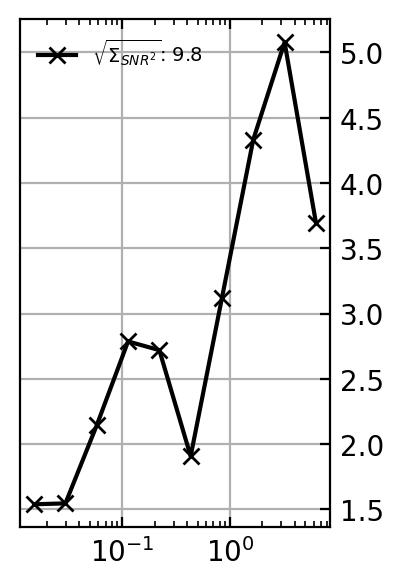

In [ ]:
fig, total = plt.subplots(1,1, dpi = 200, figsize = (2,3.3))
total.semilogx(k4, np.sqrt(SNR_by_k), color = 'black', marker = 'x', 
        label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(totQuadSNR,2)))
total.grid()
total.legend(fontsize = 7)
total.yaxis.tick_right()

In [ ]:
def quadsum(arr):
    return np.sqrt(np.sum(arr[~np.isnan(arr)]**2))

In [ ]:
nGalList = np.logspace(-5, -2, 50)
SNRx_as_nGal = np.zeros(len(nGalList))

for i,n in enumerate(nGalList):
    x_shot = fs * Iciis[2] / n # cross shot for TIMxGal
    Pcross = (bstar * Iciis[2] * Igal * Pms[2][1]) + x_shots[2]
    
    VARxTIM = (Pcross**2 + (N_TIM[2] + P_TIM[2]) * (1/n +P_gal[2])) / (2*nModes[2])
    
    SNRx_as_nGal[i] = quadsum(Pcross / np.sqrt(VARxTIM))

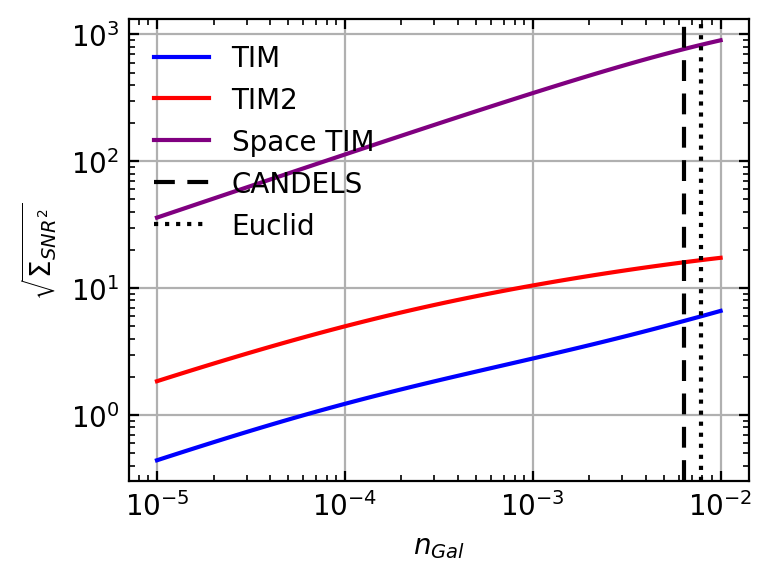

In [ ]:
plt.figure(dpi = 200, figsize = (4,3))

TIM1 = np.load('SNRx_as_nGal_TIM_Vanilla.png.npy')
TIM2 = np.load('SNRx_as_nGal_TIM_Double_detector.npy')
TIMSpace = np.load('SNRx_as_nGal_TIM_Space.npy')

plt.loglog(nGalList, TIM1, label = 'TIM', ls = '-', color = 'blue')
plt.loglog(nGalList, TIM2, label = 'TIM2', ls = '-', color = 'red')
plt.loglog(nGalList, TIMSpace, label = 'Space TIM', ls = '-', color = 'purple')

plt.axvline(p.AstroDeep.n_gals[2], label = 'CANDELS', ls = '--', color = 'black')
plt.axvline(p.Euclid.n_gals[2], label = 'Euclid', ls = ':', color = 'black')

plt.xlabel(r'$n_{Gal}$')
plt.ylabel(r'$\sqrt{\Sigma_{SNR^2}}$')

plt.legend()
plt.grid()

In [ ]:

ICII_Vars = [(b_CII*b_gal*Ps)**2/VARs for (_,Ps), VARs, shot in zip(Pms, VARx, x_shots)] # Calculate the ICII Variances
ICIISigsTot = [np.sqrt(1/np.sum(IVar)) for IVar in ICII_Vars] # Calculate the ICII Signal-to-Noise Ratios

if saveSig:
    for i in [1,2,3,4]:
        if saveWhich == 'TIMS':
            np.save('TIMSpace_sig_bin' + str(i) + '.npy', VARx[i-1])
            np.save('TIMSpace_k_bin' + str(i) + '.npy', Pms[i-1][0])
            np.save('nModesSpace' + str(i) + '.npy', nModes[i-1])
            np.save('TIMSpace_ICIIsigs.npy', ICIISigsTot)
            np.save('TIMSpace_ICIIAges.npy', cosmo.age(bin_zs).value)
        
        elif saveWhich == 'TIM2':
            np.save('TIM2_sig_bin' + str(i) + '.npy', VARx[i-1])
            np.save('TIM2_k_bin' + str(i) + '.npy', Pms[i-1][0])
            np.save('nModesTIM2' + str(i) + '.npy', nModes[i-1])
            np.save('TIM2_ICIIsigs.npy', ICIISigsTot)
            np.save('TIM2_ICIIAges.npy', cosmo.age(bin_zs).value)
    print('Saved Over', saveWhich)

In [ ]:
ICIISigsTot

[945.6901901776399, 1479.4970728889102, 1048.0494784759305, 1315.3912493111586]

In [ ]:
'''ICII_Vars = [(b_CII*b_gal*Ps)**2/VARs for (_,Ps), VARs, shot in zip(Pms, VARx, x_shots)]

ICIISigsTot = [np.sqrt(1/np.sum(IVar)) for IVar in ICII_Vars]

saveICIISig = False
if saveICIISig:
    #np.save('TIMSpace_ICIIsigs.npy', ICIISigsTot)
    #np.save('TIMSpace_ICIIAges.npy', cosmo.age(bin_zs).value)

    #np.save('TIM2_ICIIsigs.npy', ICIISigsTot)
    #np.save('TIM2_ICIIAges.npy', cosmo.age(bin_zs).value)
        
#cosmo.age(bin_zs).value, np.asarray(ICIISigs)'''

"ICII_Vars = [(b_CII*b_gal*Ps)**2/VARs for (_,Ps), VARs, shot in zip(Pms, VARx, x_shots)]\n\nICIISigsTot = [np.sqrt(1/np.sum(IVar)) for IVar in ICII_Vars]\n\nsaveICIISig = False\nif saveICIISig:\n    #np.save('TIMSpace_ICIIsigs.npy', ICIISigsTot)\n    #np.save('TIMSpace_ICIIAges.npy', cosmo.age(bin_zs).value)\n\n    #np.save('TIM2_ICIIsigs.npy', ICIISigsTot)\n    #np.save('TIM2_ICIIAges.npy', cosmo.age(bin_zs).value)\n        \n#cosmo.age(bin_zs).value, np.asarray(ICIISigs)"

In [ ]:
spaceSig = []
spaceks = []
spaceNumks = []

TIM2Sig = []
TIM2ks = []
TIM2Numks = []

#TIMSig = []
spaceSig.append([np.asarray(np.load('TIMSpace_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
spaceks.append([np.asarray(np.load('TIMSpace_k_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
spaceNumks.append([np.asarray(np.load('nModesSpace' + str(i+1) + '.npy')) for i in np.arange(4)])

TIM2Sig.append([np.asarray(np.load('TIM2_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
TIM2ks.append([np.asarray(np.load('TIM2_k_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
TIM2Numks.append([np.asarray(np.load('nModesTIM2' + str(i+1) + '.npy')) for i in np.arange(4)])

#TIMSig.append([np.asarray(np.load('TIM2_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])


In [ ]:
def modelPx(model_params):
    modelP = model_params[:,7]
    modelShot = model_params[:,8]
    return [xPow*Pm + shot for xPow, (_,Pm), shot in zip(modelP, Pms, modelShot)]
def modelICII(model_params):
    return model_params[:,0], model_params[:,1]
preface = './model_Params_from_simim/juzz_data_model_lcii_'
ICIIPreface = './model_Params_from_simim/juzz_icii_history_model_lcii_'


pessMax_params = modelPx(np.loadtxt(preface + 'sighigh.npy', delimiter=','))
pessMin_params = modelPx(np.loadtxt(preface + 'sfrumint.npy', delimiter=','))
optiMax_params = modelPx(np.loadtxt(preface + 'p19.npy', delimiter=','))
optiMin_params = modelPx(np.loadtxt(preface + 'h17um.npy', delimiter=','))
g12 = modelPx(np.loadtxt(preface + 'g12.npy', delimiter=','))
p19 = modelPx(np.loadtxt(preface + 'p19.npy', delimiter=','))
Y22 = modelPx(np.loadtxt(preface + 'Y22.npy', delimiter=','))

pessMax_ICII = modelICII(np.loadtxt(ICIIPreface + 'sighigh.csv', delimiter=','))
pessMin_ICII = modelICII(np.loadtxt(ICIIPreface + 'sfrumint.csv', delimiter=','))
optiMax_ICII = modelICII(np.loadtxt(ICIIPreface + 'p19.csv', delimiter=','))
optiMin_ICII = modelICII(np.loadtxt(ICIIPreface + 'h17um.csv', delimiter=','))
g12_ICII = modelICII(np.loadtxt(ICIIPreface + 'g12.csv', delimiter=','))
p19_ICII = modelICII(np.loadtxt(ICIIPreface + 'p19.csv', delimiter=','))
Y22_ICII = modelICII(np.loadtxt(ICIIPreface + 'Y22.csv', delimiter=','))

simimFiducial = modelPx(np.loadtxt(preface[:-1]+'.npy', delimiter=','))
simimICII = modelICII(np.loadtxt(ICIIPreface[:-1]+'.csv', delimiter=','))

In [ ]:
first = True

for modelFile in os.listdir('./model_Params_from_simim'):
    if 'icii_history' in modelFile:
        if 'g12' in modelFile: continue
        model = np.loadtxt('./model_Params_from_simim/'+modelFile, delimiter=',')
        if first:
            modelStack = model[:,1]
            first = False
        else: modelStack = np.vstack((modelStack, model[:, 1]))
            
IciiModelMin = [modelStack[:,i][~np.isnan(modelStack[:,i])].min() for i in np.arange(len(modelStack[0,:]))]
IciiModelMax = [modelStack[:,i][~np.isnan(modelStack[:,i])].max() for i in np.arange(len(modelStack[0,:]))]

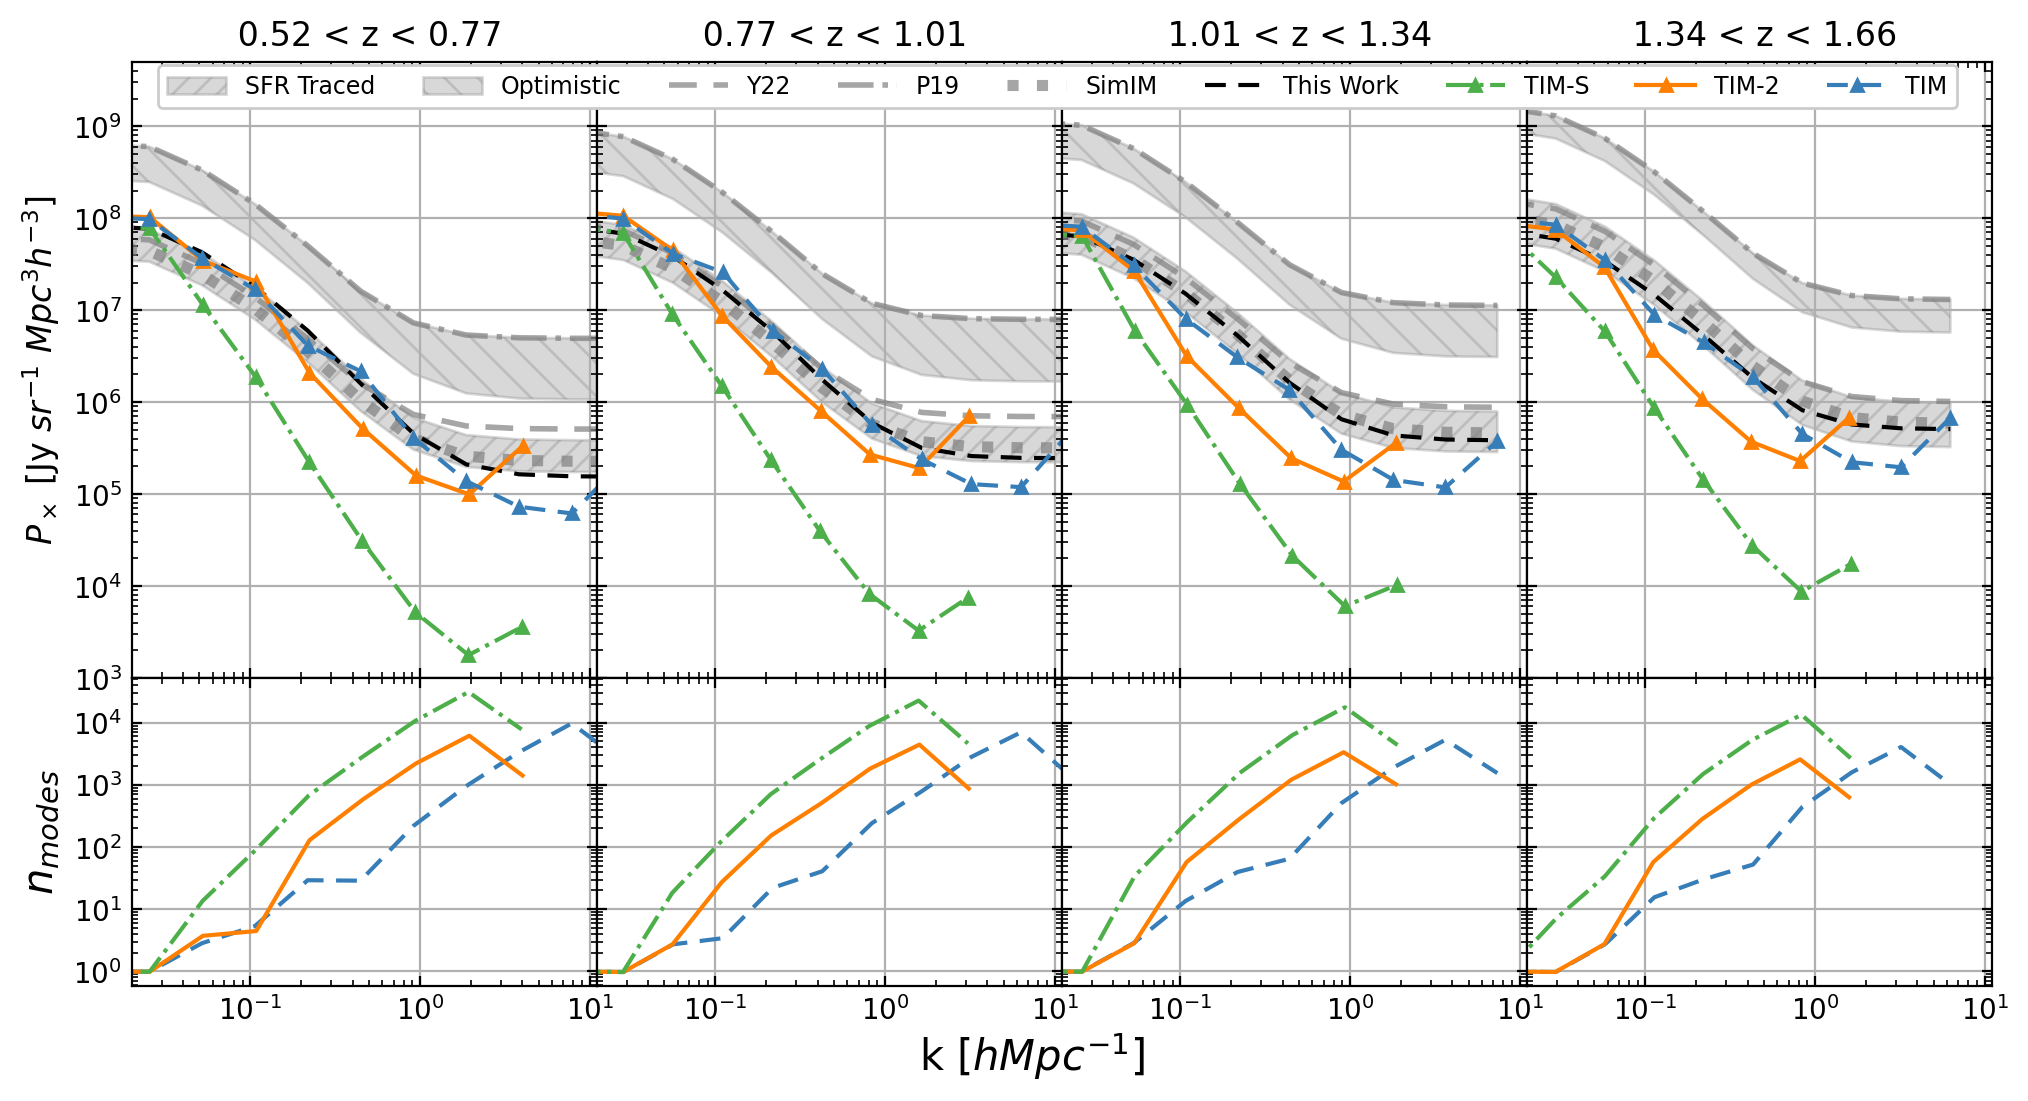

In [ ]:
fig, (plots, kplots) = plt.subplots(2,4, figsize = (12, 6), dpi = 200, sharey = 'row', sharex = True,
                                    gridspec_kw={'height_ratios': [4,2]})

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

TIMcolor = CB_color_cycle[0]
TIM2color = CB_color_cycle[1]
TIMScolor = CB_color_cycle[2]

    
for i in np.arange(0,4):
    
    plots[i].fill_between(Pms[i][0], pessMax_params[i], pessMin_params[i], color = 'grey', alpha = 0.3, hatch = '///',
                          label = 'SFR Traced')
    plots[i].fill_between(Pms[i][0], optiMax_params[i], optiMin_params[i], color = 'grey', alpha = 0.3, hatch = '\\\\',
                          label = 'Optimistic')
    
    plots[i].loglog(Pms[i][0], Y22[i], label = 'Y22', ls = '--', lw = 2, color = 'grey', alpha = 0.7)
    plots[i].loglog(Pms[i][0], p19[i], label = 'P19', ls = '-.', lw = 2, color = 'grey', alpha = 0.7)
    #plots[i].loglog(Pms[i][0], g12[i], label = 'G12', ls = '--', lw = 2, color = 'TIM2color')
    
    plots[i].loglog(Pms[i][0], simimFiducial[i], color = 'grey', label = 'SimIM', ls = ':', lw = 4, alpha = 0.7)
    plots[i].loglog(Pms[i][0], PxGs[i], color = 'k', linestyle = '--', label = 'This Work')
    
    plots[i].loglog(spaceks[0][i], np.sqrt(spaceSig[0][i]), marker = '^', label = 'TIM-S', ms = 4,
                    color = TIMScolor, ls = '-.')
    plots[i].loglog(TIM2ks[0][i], np.sqrt(TIM2Sig[0][i]), marker = '^', label = 'TIM-2', ms = 4,
                    color = TIM2color, ls = '-')
    #plots[i].loglog(Pms[i][0], np.sqrt(clusterVar[i]))
    #plots[i].loglog(Pms[i][0], P[i])
    #plots[i].loglog(Pms[i][0], np.sqrt(N_TIM[i]*P_gal[i]/(2*nModes[i])), label = r'$P_N P_{Gal} / 2n_{modes}$', ls = '--')
    plots[i].grid()
    kplots[i].grid()
    
    plots[i].set_title(f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")
    kplots[i].loglog(Pms[i][0], nModes[i], color = TIMcolor, marker = '', ls = '--')
    kplots[i].loglog(TIM2ks[0][i], TIM2Numks[0][i], color = TIM2color, marker = '', ms = 10, ls = '-')
    kplots[i].loglog(spaceks[0][i], spaceNumks[0][i], color = TIMScolor, marker = '', ls = '-.')
    

[plots[i].loglog(ks, np.sqrt(VARs), ls = '--', marker = '^', color = TIMcolor, label = 'TIM', ms = 4) 
         for i, (VARs, (ks,_)) in enumerate(zip(VARx, Pms))]


#kplots[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=15, loc = 'left')
fig.text(0.5, 0.04, r"k [$h Mpc^{-1}]$", size=15, ha='center')
plots[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 12)
kplots[0].set_ylabel(r"$n_{modes}$", size = 15)
plots[2].set_xlim(2e-2,1.1e1)
plots[0].set_ylim(1e3,5e9)

plots[3].legend(loc='center right', bbox_to_anchor=(0.95, 0.96), frameon = True, fontsize = 8.5,
      ncol=9, fancybox=True, shadow=False, framealpha = 1, handlelength=2.5)
#plots[0].legend(fontsize = 9)
#fig.subplots_adjust(hspace=0., wspace=0.06)
fig.subplots_adjust(hspace=0., wspace=0.00)

In [ ]:
TIMS_age = np.load('TIMSpace_ICIIAges.npy')
TIM2_age = np.load('TIM2_ICIIAges.npy')
TIMS_sig = np.load('TIMSpace_ICIIsigs.npy')
TIM2_sig = np.load('TIM2_ICIIsigs.npy')

In [ ]:
binExtents = [(zBin.back) - (zBin.front) for zBin in bins]
binExtents = np.asarray(binExtents)/2

In [ ]:
ICIISigsTot

[945.6901901776399, 1479.4970728889102, 1048.0494784759305, 1315.3912493111586]

In [ ]:
 L0=8.3 * 10**6 * u.Lsun * u.yr / u.Msun
SFu = (u.M_sun/u.yr/u.Mpc**3)

def ItoSFRD(I):
    if not hasattr(I, "unit"):
        I = I * u.Jy
    SFRD = 4*np.pi*cosmo.H0*CII.nu*I / (c.c*L0)
    return SFRD.to(u.M_sun/u.yr/u.Mpc**3).value

def SFRDtoI(SFRD):
    if not hasattr(SFRD, "unit"):
        SFRD = SFRD * SFu

    I = c.c * L0 * SFRD / (4*np.pi*cosmo.H0*CII.nu)
    return I.to(u.Jy).value

ItoSFRD(10**5*u.Jy), SFRDtoI(1.6*u.M_sun/u.yr/u.Mpc**3)

(1.6152921777270706, 99053.28720475892)

In [ ]:
zgrid = np.linspace(0,30,3001)
agegrid = cosmo.age(zgrid).value
def transform(z):
    return np.interp(z, zgrid, agegrid)
def itransform(age):
    return np.interp(age, agegrid[::-1], zgrid[::-1])

def setup_history(ax,zlim=[5,0],zticks=[0,1,2,5],zticklabels=None,timeticks=np.array([1,3,5,7,9,11,13]),timeticklabels=None):
    if zticklabels is None:
        zticklabels = zticks
    if timeticklabels is None:
        timeticklabels = timeticks
    ax.set_xscale('function',functions=(transform,itransform))
    ax.set(xlim=zlim, xlabel='Age of Universe [Gyr]', xticks=itransform(timeticks), xticklabels=timeticklabels)
    ax.set(yscale='log')
    
    ax2 = ax.twiny()
    ax2.set_xscale('function',functions=(transform,itransform))
    ax2.set(xlim=zlim,xlabel='Redshift',xticks=zticks,xticklabels=zticklabels)

    return ax, ax2

AttributeError: module 'E_lines' has no attribute 'Inu_proposal'

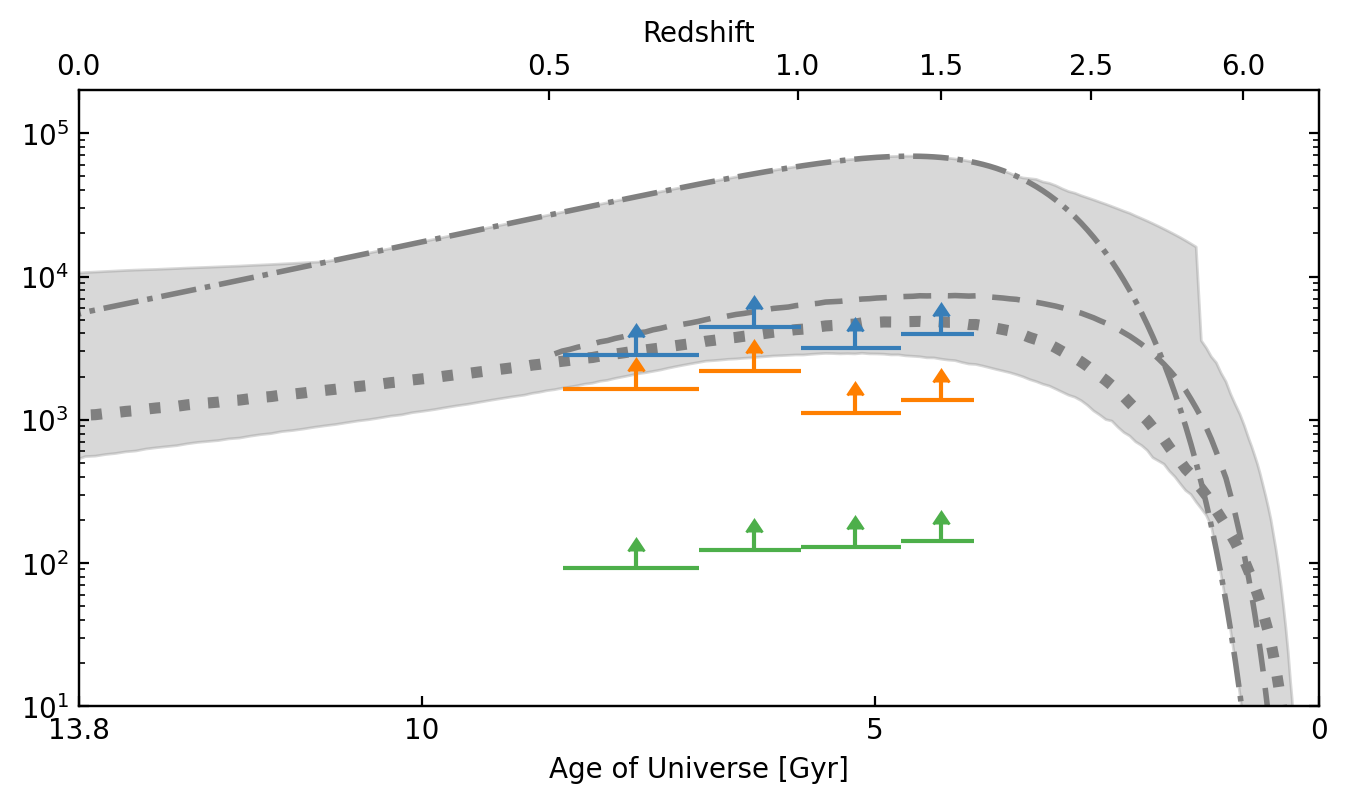

In [ ]:

fig, ax = plt.subplots(dpi = 200, figsize = [8,4])
#ax.semilogy(bin_zs, Iciis, color = 'k', ls = '--', label = 'This Work')

ax.semilogy(simimICII[0], simimICII[1], color = 'grey', label = 'SimIM', ls = ':', lw = 4)
ax.semilogy(Y22_ICII[0], Y22_ICII[1], label = 'Y22', ls = '--', lw = 2, color = 'grey')
ax.semilogy(p19_ICII[0], p19_ICII[1], label = 'P19', ls = '-.', lw = 2, color = 'grey')
#ax.fill_between(cosmo.age(pessMax_ICII[0]).value, pessMax_ICII[1], pessMin_ICII[1], color = 'grey', alpha = 0.3, hatch = '///',
#                          label = 'SFR Traced')
ax.fill_between(pessMax_ICII[0], IciiModelMax, IciiModelMin, color = 'grey', alpha = 0.3,
                          label = 'Model Space')

#ax.semilogy(cosmo.age(bin_zs).value, 3*Iciis/quad_SNRs_Clust, color = 'k', ls = '', marker = '^',  label = r'TIM $3\sigma$')
#ax.semilogy(cosmo.age(bin_zs).value, 3*np.asarray(ICIISigsTot), color = 'r', ls = '', marker = '^',  
#             label = r'TIM $3\sigma$')
#ax.semilogy(TIMS_age, 3*TIMS_sig, marker = '^', label = 'BG Lim $3\sigma$', color = TIMScolor, ls = '')
#ax.semilogy(TIM2_age, 3*TIM2_sig, marker = '^', label = 'Atm Lim $3\sigma$', color = TIM2color, ls = '')

sig3 = 3*np.asarray(ICIISigsTot)

ax.errorbar(bin_zs, sig3, xerr=binExtents, yerr= sig3/3, lolims=True, 
             label = 'TIM $3\sigma$', color = TIMcolor, ls = '')
ax.errorbar(bin_zs, 3*TIM2_sig, xerr=binExtents, yerr= TIM2_sig, lolims=True, 
             label = 'TIM2 $3\sigma$', color = TIM2color, ls = '')
ax.errorbar(bin_zs, 3*TIMS_sig, xerr=binExtents, yerr= TIMS_sig, lolims=True, 
             label = 'TIM-S $3\sigma$', color = TIMScolor, ls = '')

ax.set_xlabel("Age of the Universe (Gyr)")
ax.set_ylim(10, 2e5)
ax.set_xlim(0,13)


zticks = np.array([0,0.5,1.0,1.5,2.5,6])
timeticks = np.array([0.0,5,10,cosmo.age(0).value])
timeticklabels = ['0','5','10','{:.1f}'.format(cosmo.age(0).value)]
ax, ax_time = setup_history(ax,zlim=(100,0),zticks=zticks,zticklabels=None,timeticks=timeticks,timeticklabels=timeticklabels)

zList = np.linspace(0,13,100)
SFRDList = ut.MD_sfrd(zList)
IList = l.Inu_proposal(SFRDList, zList)
ax.semilogy(zList, IList, color = 'k', ls = '--', label = 'This Work')


'''ax2 = ax.twinx()
mn, mx = ax.get_ylim()
#Is = np.logspace(np.log10(mn), np.log10(mx), 5)*u.Jy
Is = np.asarray([10, 10**2, 10**3, 10**4, 10**5])*u.Jy
SFRDticks = np.log10([ItoSFRD(I).value for I in Is])
#ax2.set_ylim(ItoSFRD(mn*u.Jy).value, ItoSFRD(mx*u.Jy).value)
ax2.set_yticks(SFRDticks)
#ax2.set_yscale("log")
ax2.set_ylabel(r'SFRD [$M_\odot$ $Mpc^{-3}$ $yr^{-1}]$')'''

ax2 = ax.secondary_yaxis('right', functions=(ItoSFRD, SFRDtoI))
ax2.set_ylabel(r'SFRD [$M_\odot$ $Mpc^{-3}$ $yr^{-1}]$')


ax.set_xlabel("Age of the Universe (Gyr)")
ax.set_ylabel(r"<$I_{[CII]}$> (Jy $sr^{-1}$)")
#ax.legend(loc='center right', frameon = True, fontsize = 6,
#      ncol=8, fancybox=True, shadow=False, bbox_to_anchor=(0.98, 0.95), handlelength=2.5)
ax.legend(ncol = 2, fontsize = 8, handlelength=2.5,frameon = True, framealpha = 1)
ax.grid()



In [ ]:
sig3
binExtents

In [ ]:
# saveSig = False
# if saveSig:
#    for i in [1,2,3,4]:
        #np.save('TIMSpace_sig_bin' + str(i) + '.npy', VARx[i-1])
        #np.save('TIMSpace_k_bin' + str(i) + '.npy', Pms[i-1][0])
        #np.save('nModesSpace' + str(i) + '.npy', nModes[i-1])
        
        #np.save('TIM2_sig_bin' + str(i) + '.npy', VARx[i-1])
        #np.save('TIM2_k_bin' + str(i) + '.npy', Pms[i-1][0])
        #np.save('nModesTIM2' + str(i) + '.npy', nModes[i-1])'''

In [ ]:
saveICIISig = False
if saveICIISig:
    #np.save('TIMSpace_ICIIsigs.npy', ICIISigsTot)
    #np.save('TIMSpace_ICIIAges.npy', cosmo.age(bin_zs).value)

    #np.save('TIM2_ICIIsigs.npy', ICIISigsTot)
    #np.save('TIM2_ICIIAges.npy', cosmo.age(bin_zs).value)
        
#cosmo.age(bin_zs).value, np.asarray(ICIISigs)

In [ ]:
[plt.loglog(ks, Px) for (ks,_), Px in zip(Pms, ModelPx)]

In [ ]:
midks = Pms[2][0]
midPm = Pms[2][1]

In [ ]:
len(Pms[0][1])

In [ ]:
[print(len(var)) for var in VARx]

In [ ]:
len(np.load('TIMSpace_sig_bin4.npy'))

In [ ]:
for i in [1,2,3,4]:
    print(len(VARx[i-1]))

In [ ]:
np.load('TIMSpace_sig_bin4.npy')